In [17]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from backtest_functions_v2 import *

In [18]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [19]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa']
['adoption_absa', 'cybersecurity_absa', 'return_forward', 'sma_5_20_diff', 'sma_20_50_diff']
['sma_50_200_diff', 'ema_5_20_diff', 'ema_20_50_diff', 'ema_50_200_diff', 'sma_5_20_diff_abs_chg']
['sma_5_20_diff_pct_chg', 'sma_20_50_diff_abs_chg', 'sma_20_50_diff_pct_chg', 'sma_50_200_diff_abs_chg', 'sma_50_200_diff_pct_chg']
['ema_5_20_diff_abs_chg', 'ema_5_20_diff_pct_chg', 'ema_20_50_diff_abs_chg', 'ema_20_50_diff_pct_chg', 'ema_50_200_diff_abs_chg']
['ema_50_200_diff_pct_chg', 'macd_12_26', 'signal_line_9', 'macd_histogram', 'macd_position']
['macd_crossover', 'adx', '+di', '-di', 'adx_slope']
['adx_strength', 'di_crossover', 'di_spread', 'adx_di_composite', 'rsi_7']
['rsi_14', 'rsi_7_slope', 'rsi_7_chg', 'rsi_7_acceleration', 'rsi_14_slope']
['rsi_14_chg', 'rsi_14_acceleration', 'rsi_ratio', 'atr_7', 'atr_14']
['atr_7_slope', 'atr_7_chg', 'atr_14_slope', 'atr_14_chg', 'norm_price_change_7']
['norm_p

### Spliting dataset

In [20]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [21]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Logistic regression model - using all features

In [22]:
selected_features = [
  'news_count', 'tanalysis_absa'
]

# Create training and testing sets with manually selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("Selected features for manual model:")
print(selected_features)
print("\nShape of X_train_manual:", X_train.shape)
print("Shape of X_test_manual:", X_test.shape)

Selected features for manual model:
['news_count', 'tanalysis_absa']

Shape of X_train_manual: (26274, 2)
Shape of X_test_manual: (8784, 2)


In [23]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('logreg', LogisticRegression(solver='saga', random_state=42, class_weight='balanced', max_iter=15000))
])

# Parameter grid for GridSearchCV - Expanded
param_grid = {
  'logreg__C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
  'logreg__penalty': ['l1', 'l2']
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV - Changed scoring to f1_weighted
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data - Using all features
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"GridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation f1_weighted score: ", grid_search.best_score_)

# Get the best estimator
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
GridSearchCV fitting time: 0.52 seconds
Best parameters found:  {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best cross-validation f1_weighted score:  0.3641066753711889


In [24]:
# Make predictions on the test set - Using all features
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# For multiclass ROC AUC, specify multi_class='ovr' or 'ovo' and provide probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

Test Set Accuracy: 0.3797

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.49      0.40      2648
           1       0.48      0.37      0.42      3274
           2       0.34      0.28      0.31      2862

    accuracy                           0.38      8784
   macro avg       0.39      0.38      0.38      8784
weighted avg       0.39      0.38      0.38      8784


Confusion Matrix:
[[1301  661  686]
 [1169 1227  878]
 [1369  686  807]]

ROC AUC Score (One-vs-Rest): 0.5604


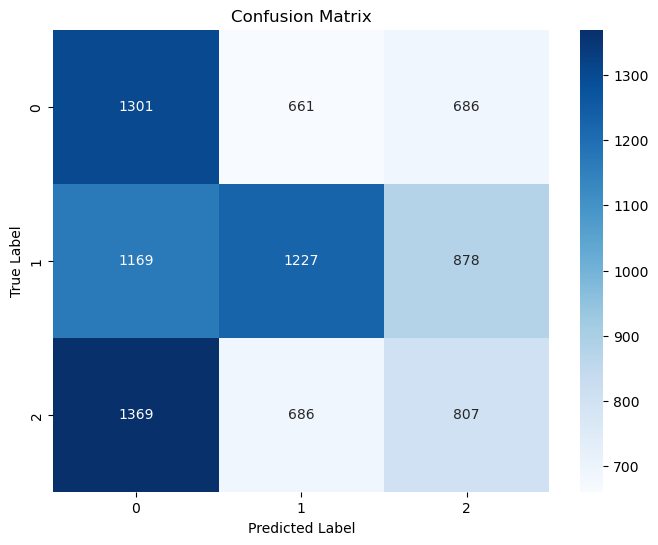

In [25]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model Coefficients:
                 Class 0   Class 1  Class 2
news_count      0.008839 -0.100100      0.0
tanalysis_absa -0.032384  0.034394      0.0


<Figure size 2500x500 with 0 Axes>

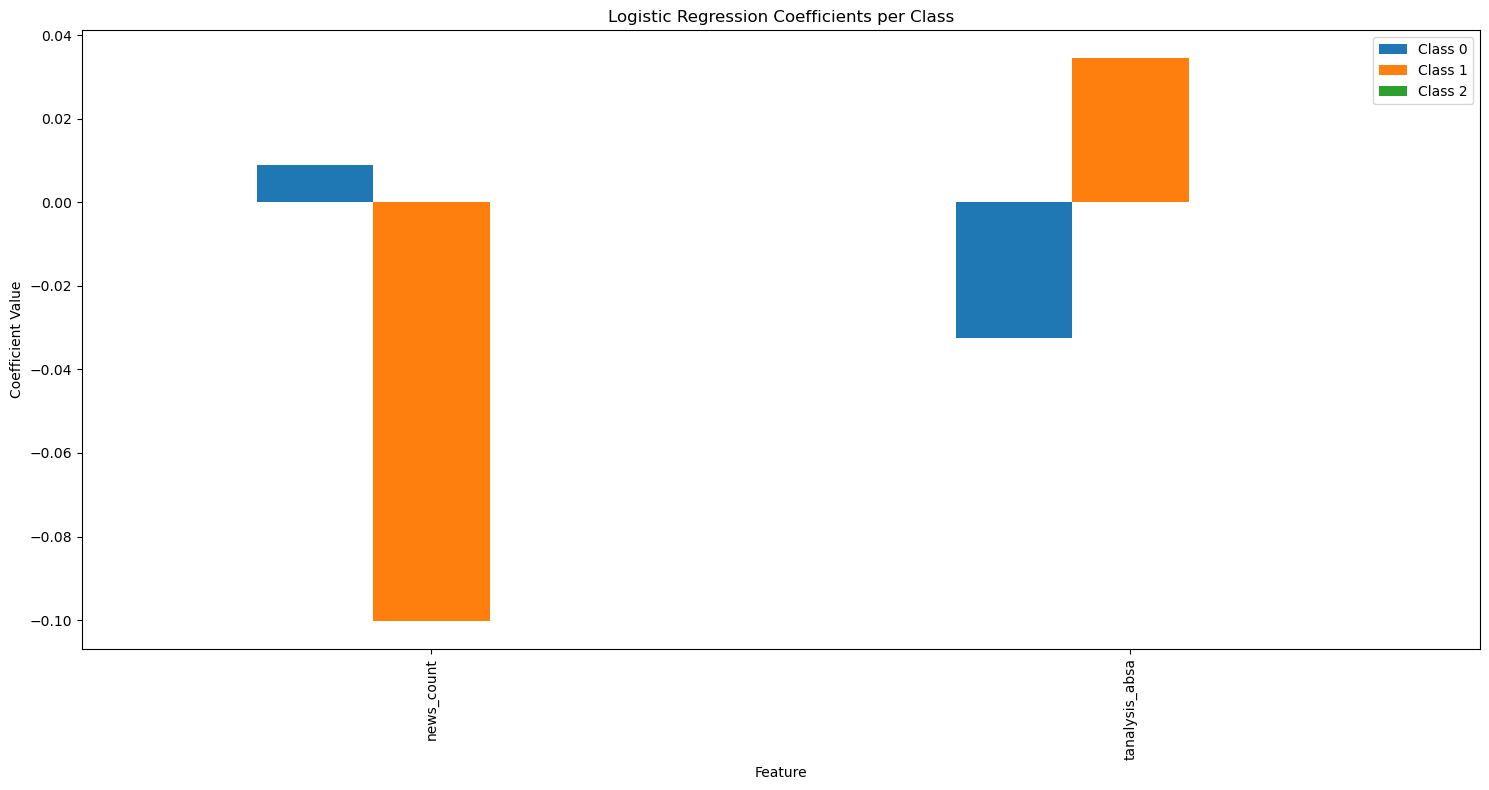

In [26]:
# Get the coefficients from the logistic regression model within the pipeline
coefficients = best_model.named_steps['logreg'].coef_

# Create a DataFrame to display coefficients for each class - Using all features
coef_df = pd.DataFrame(coefficients, columns=selected_features, index=['Class 0', 'Class 1', 'Class 2'])

print("Model Coefficients:")
# Transpose for better readability if there are many features
print(coef_df.T)

# Optionally, plot the coefficients for visualization
plt.figure(figsize=(25, 5)) # Adjusted figure size for more features
coef_df.T.plot(kind='bar', figsize=(15, 8)) # Adjusted figure size
plt.title('Logistic Regression Coefficients per Class')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [27]:
# Make prediction on the test set using the best model - Using all features
df_test['signal'] = best_model.predict(X_test)

# Display the first few rows with the new signal column
print(df_test[['target', 'signal']].head())

# Check the distribution of the predicted signals
print("\nPredicted signal distribution:")
print(df_test['signal'].value_counts())

                     target  signal
2024-01-01 00:00:00       0       1
2024-01-01 01:00:00       1       1
2024-01-01 02:00:00       0       0
2024-01-01 03:00:00       1       1
2024-01-01 04:00:00       2       1

Predicted signal distribution:
signal
0    3839
1    2574
2    2371
Name: count, dtype: int64


Overall Annual Return: 3.53%
Overall Annual Sharpe Ratio: 0.3116
Maximum Drawdown: -51.43 %
Alpha: 0.5123
Beta: -0.2841

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.035303    0.478781    -0.284057      0.413618       0.311611


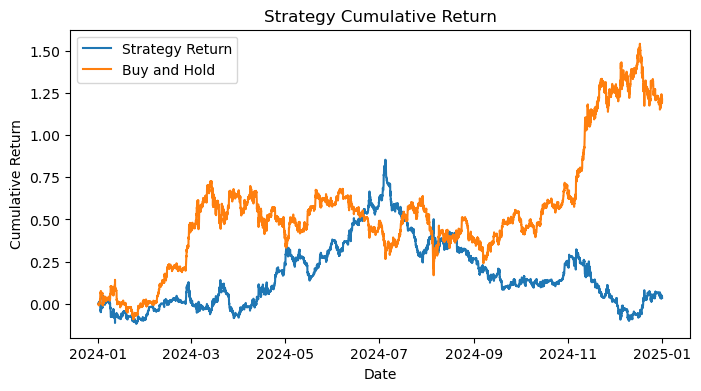

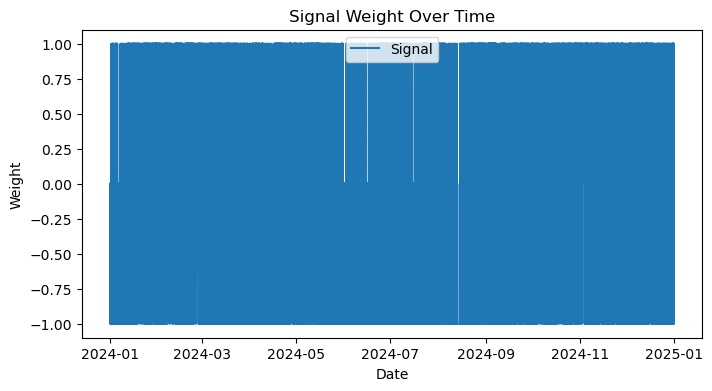

In [28]:
df_test['signal'] = df_test['signal'] - 1
run_backtest(df_test, 'h')

### Logistic regression model - absa columns only

In [29]:
# Correctly define the list of selected features
selected_features = [
    'tanalysis_absa_ewm_12h'
    'economy_absa_ewm_12h',
    'regulation_absa_ewm_12h',
    'technology_absa_ewm_12h',
    'adoption_absa_ewm_12h',
    'news_count', 'tanalysis_absa', 'economy_absa', 
    'regulation_absa', 'technology_absa'
]

# Select the specified features from the training and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

KeyError: "['tanalysis_absa_ewm_12heconomy_absa_ewm_12h', 'regulation_absa_ewm_12h', 'technology_absa_ewm_12h', 'adoption_absa_ewm_12h', 'economy_absa', 'regulation_absa', 'technology_absa'] not in index"

In [ ]:
# Define the pipeline with scaler and logistic regression
pipeline_selected = Pipeline([
  ('scaler', StandardScaler()),
  ('logreg', LogisticRegression(solver='saga', random_state=42, class_weight='balanced', max_iter=15000))
])

# Parameter grid for GridSearchCV (same as before)
param_grid_selected = {
  'logreg__C': [0.01, 0.1, 1, 10],
  'logreg__penalty': ['l1']
}

# Time series cross-validation (same as before)
tscv_selected = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with the selected features pipeline
grid_search_selected = GridSearchCV(pipeline_selected, param_grid_selected, cv=tscv_selected, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data with selected features
start_time_selected = time.time()
grid_search_selected.fit(X_train_selected, y_train)
end_time_selected = time.time()

print(f"GridSearchCV fitting time (selected features): {end_time_selected - start_time_selected:.2f} seconds")
print("Best parameters found (selected features): ", grid_search_selected.best_params_)
print("Best cross-validation f1_weighted score (selected features): ", grid_search_selected.best_score_)

# Get the best estimator for selected features
best_model_selected = grid_search_selected.best_estimator_

In [ ]:
# Make predictions on the test set using the model trained on selected features
y_pred_selected = best_model_selected.predict(X_test_selected)
y_pred_proba_selected = best_model_selected.predict_proba(X_test_selected)

# Evaluate the model
accuracy_selected = accuracy_score(y_test, y_pred_selected)
report_selected = classification_report(y_test, y_pred_selected)
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected, multi_class='ovr')

print(f"Test Set Accuracy (selected features): {accuracy_selected:.4f}")
print("\nClassification Report (selected features):")
print(report_selected)
print("\nConfusion Matrix (selected features):")
print(conf_matrix_selected)
print(f"\nROC AUC Score (One-vs-Rest, selected features): {roc_auc_selected:.4f}")

In [ ]:
# Plot confusion matrix for the model with selected features
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Selected Features)')
plt.show()

In [ ]:
# Get the coefficients from the logistic regression model (selected features) within the pipeline
coefficients_selected = best_model_selected.named_steps['logreg'].coef_

# Create a DataFrame to display coefficients for each class - Using selected features
coef_df_selected = pd.DataFrame(coefficients_selected, columns=selected_features, index=['Class 0', 'Class 1', 'Class 2'])

print("Model Coefficients (Selected Features):")
# Transpose for better readability
print(coef_df_selected.T)

# Optionally, plot the coefficients for visualization
plt.figure(figsize=(15, 5)) # Adjusted figure size
coef_df_selected.T.plot(kind='bar', figsize=(12, 6)) # Adjusted figure size
plt.title('Logistic Regression Coefficients per Class (Selected Features)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Make prediction on the test set using the best model - Using selected features
# Create a copy to avoid SettingWithCopyWarning
df_test_selected = df_test.copy()
df_test_selected['signal'] = best_model_selected.predict(X_test_selected)

# Display the first few rows with the new signal column
print(df_test_selected[['target', 'signal']].head())

# Check the distribution of the predicted signals
print("\nPredicted signal distribution (selected features):")
print(df_test_selected['signal'].value_counts())

In [ ]:
df_test['signal'] = df_test['signal'] - 1
run_backtest(df_test, 'h')